# INFO-F-422 Project 23-24 : Zindi: - Urban Air Pollution Challenge - 

## Description of the Project

### Problem

### Data

### scoring metric

## Tasks

### Packages

In [29]:
library(dplyr)
library(randomForest)
library(ggplot2)
library(RSNNS)
library(e1071)
library(xgboost)
library(keras)
library(repr)
library(caret)
library(lubridate)
library(VIM)
library(lightgbm)

options(repr.matrix.max.cols=500, repr.matrix.max.rows=200)
#set.seed(42)

### 1. Pipeline
This section will contain a few functions that can be called to modify, complete or create new features.`

These Functions can then after be called easilly to try different combinations.

#### Data importation & Feature selection

In [5]:
get_train_data <- function() {
    train_df <- read.csv("Data/Train.csv")
    train_df <- train_df %>% 
        select(-"target_min", -"target_max",-"target_variance",-"target_count",-"Place_ID.X.Date")
    return(train_df)
}

In [17]:
get_test_data <- function() {
    train_df <- read.csv("Data/Test.csv")
    train_df <- train_df %>% 
        select(-"Date")
    return(train_df)
}

#### Missing value imputation

In [8]:
# Drop na's
drop_na <- function(data) {
    data_clean <- data[, colSums(is.na(data)) == 0]
    return(data_clean)
}

In [9]:
# Replace na's by mean
na_to_mean <- function(data) {
    data_clean <- data %>%
        mutate(across(everything(), ~ifelse(is.na(.), mean(., na.rm = TRUE), .)))
    return(data_clean)
}

In [10]:
# Replace na's by median
na_to_median <- function(data) {
    data_clean <- data %>%
        mutate(across(everything(), ~ifelse(is.na(.), median(., na.rm = TRUE), .)))
    return(data_clean)
}

In [11]:
# Replace na's by the median by Place_ID
na_to_median_by_location <- function(data) {
    data_clean <- data %>%
        group_by(Place_ID) %>%
        mutate(across(where(is.numeric), ~ifelse(is.na(.), median(., na.rm = TRUE), .))) %>%
        ungroup()
    
    return(data_clean)
}

#### Normalization

In [12]:
#Function that will normalize all the columns
normalize <- function(x) {
  (x - min(x, na.rm = TRUE)) / (max(x, na.rm = TRUE) - min(x, na.rm = TRUE))
}

#### Feature engineering

In [19]:
# Add columns for day, mounth, year, day of the week and if it is weekend or not.
add_time <- function(data) {
    data <- data %>%
        mutate(day = day(Date),
               month = month(Date),
               year = year(Date),
               day_of_week = wday(Date),
               s_weekend = as.integer(wday(Date) %in% c(6, 7)))
    data <- data %>%
        group_by(Place_ID) %>%
        mutate(placeID_freq = n()) %>%
        ungroup()

    return(data)
}

In [20]:
# Function to add lag, lead of all the columns enabeling it to see what was before and after
add_lag_lead <- function(data, days) {
    # Features: Excluding specific columns from the dataset
    features <- setdiff(names(data), c("Date", "target_count", "target_min", "Place_ID X Date", "target_variance", "target_max", "Place_ID.X.Date", "target"))
    
    numeric_features <- sapply(data, is.numeric)
    features <- names(numeric_features[numeric_features == TRUE])
    features <- setdiff(features, c("target", "Place_ID.X.Date", "Date"))
    
    # Wrap operations in a group_by() without arranging
    data <- data %>%
        group_by(Place_ID) %>%
        mutate(across(all_of(features), ~lag(.x, 1), .names = "prev_{.col}_1"),
               across(all_of(features), ~lead(.x, 1), .names = "next_{.col}_1")) %>%
        ungroup()  # Return to regular data frame operation without groups
    
    # Now create the difference features
    for (i in 1:days) {
        # Creating difference features for lag
        data <- data %>%
            group_by(Place_ID) %>%
            mutate(across(all_of(features), ~. - lag(., i), .names = paste0("prev_{.col}_", i+1))) %>%
            ungroup()
        
        # Creating difference features for lead
        data <- data %>%
            group_by(Place_ID) %>%
            mutate(across(all_of(features), ~. - lead(., i), .names = paste0("next_{.col}_", i+1))) %>%
            ungroup()
    }
    
    # Replace NA values in numeric columns with 0
    numeric_columns <- sapply(data, is.numeric)
    data[numeric_columns] <- lapply(data[numeric_columns], function(x) replace(x, is.na(x), 0))
    
    return(data)
}


#### Divide train / validation set

In [22]:
# randomise stations in train and val by grouping the Place_ID's
# This allows to not overfit with the test data that doesn't contain similar Place_ID's as the training data
get_train_val <- function(data,rep) {
    unique_place_ids <- unique(data$Place_ID)
    shuffled_place_ids <- sample(unique_place_ids)
    unique_place_ids <- unique(data$Place_ID)
    shuffled_place_ids <- sample(unique_place_ids)
    num_train <- round(length(shuffled_place_ids) * rep)
    train_ids <- shuffled_place_ids[1:num_train]
    val_ids <- shuffled_place_ids[(num_train + 1):length(shuffled_place_ids)]
    train <- data[data$Place_ID %in% train_ids, ] %>% 
      select(-"Place_ID")
    val <- data[data$Place_ID %in% val_ids, ] %>% 
      select(-"Place_ID")
    return(list(train = train, val = val))
}

#### Configuration grid
This allows to decide for each test which mission value imputation, normalization, feature engeneering and train_val repartition to use

In [23]:
train = get_train_data()
test = get_test_data()
data <- bind_rows(train, test)
data <- na_to_median_by_location(data)
data <- add_time(data)
data <- add_lag_lead(data,10)
features <- setdiff(names(data), c("Date", "Place_ID X Date","Place_ID.X.Date"))
train_data <- data[1:nrow(train), features, drop = FALSE]
test_data <- data[(nrow(train) + 1):nrow(data), features, drop = FALSE]
data_test_val <- get_train_val(train_data ,0.8)

#### Plot repartition of the data

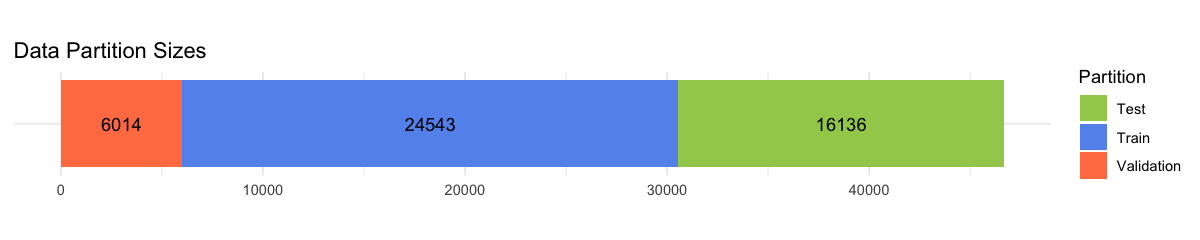

In [36]:
partition_sizes <- data.frame(
  Partition = c("Train", "Validation", "Test"),
  Size = c(nrow(data_test_val$train), nrow(data_test_val$val), nrow(test_data))
)

# Plot the partition sizes
options(repr.plot.width = 10, repr.plot.height = 2)
ggplot(partition_sizes, aes(x = "", y = Size, fill = Partition)) +
  geom_bar(stat = "identity", width = 1) +
  coord_flip() +
  geom_text(aes(label = Size), position = position_stack(vjust = 0.5)) +
  theme_minimal() +
  labs(title = "Data Partition Sizes", x = NULL, y = NULL) +
  scale_fill_manual(values = c("Train" = "cornflowerblue", "Validation" = "coral", "Test" = "darkolivegreen3")) +
  theme(
    axis.ticks = element_blank(), 
    axis.text.y = element_blank(),
    aspect.ratio = 1/10 # Adjust the aspect ratio to make the plot shorter
  )

### 2. Model selection

### 3.

### 4.

## Competition results

## Further implementations to increase the score